## 개요
- 데이터: 2016년 1월 1일 ~ 2021년 1월 1일의 전종목 데이터
- 검증 내용: (1) 요일별 등락률 분포 (2) 월요일에 매수해서 금요일에 매도하는 전략의 수익률

In [1]:
# 필요 모듈 불러오기
from qspy import datasets
from qspy.analysis import calendar_effect
from qspy.validation import ror_buy_and_sell, ror_buy_and_hold
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## 데이터 준비 

In [2]:
# 2016년 1월 1일 이전 코스피 혹은 코스닥에 상장된 모든 종목 정보를 stock_list에 저장
stock_list = datasets.load_stock_list(market = "all")
stock_list = stock_list.loc[stock_list['ListingDate'] < pd.to_datetime("2016-01-01")]

In [3]:
# stock_list의 Symbol 컬럼을 기준으로 2018년 1월 1일부터 2021년 1월 1일까지의 데이터 불러오기
data_list = datasets.load_stock_data_list(stock_list["Symbol"],
                                          start_date = "2016-01-01",
                                          end_date = "2021-01-01",
                                          download = False)

In [4]:
# 저가가 0인 문제가 있는 레코드 제거
data_list = [data.loc[data['Low'] != 0].reset_index(drop = True) for data in data_list]

## 요일별 등락률 분포 확인

In [5]:
# 요일별 등락률을 담을 리스트 초기화 
change_list = [[], [], [], [], []]

In [6]:
# Date의 weekday를 바탕으로 change_list에 저장
for data in data_list:
    data["요일"] = data["Date"].dt.weekday # dt.weekday: 날짜 자료형의 요일을 반환
    for i in range(5):
        change_list[i] += data.loc[data["요일"] == i, "Change"].dropna().tolist()

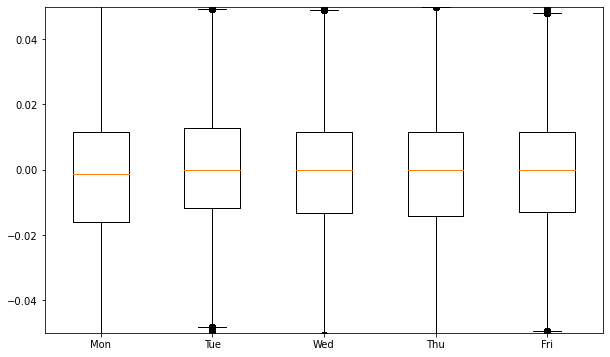

In [7]:
# 박스플롯으로 시각화해서 비교
plt.figure(figsize = (10, 6))
plt.boxplot(change_list)
plt.xticks(range(1, 6), ["Mon", "Tue", "Wed", "Thu", "Fri"])
plt.ylim(-0.05, 0.05)
plt.show()

In [8]:
# 통계량 확인
result = pd.DataFrame()
for i in range(5):
    result = pd.concat([result, pd.Series(change_list[i]).describe()], axis = 1)
result.columns = ["Mon", "Tue", "Wed", "Thu", "Fri"]
display(result.round(3))

,Mon,Tue,Wed,Thu,Fri
count,403200.000,406514.000,401619.000,411568.000,404983.000
mean,-0.001,0.002,0.001,-0.000,0.001
std,0.036,0.032,0.033,0.034,0.032
min,-0.300,-0.300,-0.300,-0.468,-0.931
25%,-0.016,-0.012,-0.013,-0.014,-0.013
50%,-0.001,0.000,0.000,0.000,0.000
75%,0.012,0.013,0.012,0.011,0.011
max,0.948,0.304,0.301,0.301,0.305


## 월요일에 매수해서 금요일에 매도하는 전략의 수익률 검증

In [9]:
# 수익률 목록 계산: 월요일 시가 - 금요일 종가, 월요일 종가 - 금요일 종가
ror_list_OC = []
ror_list_CC = []
for data in data_list:
    buy_arr, sell_arr = calendar_effect.week_effect(data, buy_weekday = 0, sell_weekday = 4, date_col = "Date")
    ror_list_OC += ror_buy_and_sell(data, buy_arr, sell_arr, buy_col = "Open", sell_col = "Close")
    ror_list_CC += ror_buy_and_sell(data, buy_arr, sell_arr, buy_col = "Close", sell_col = "Close")

In [10]:
# 임의의 시점에서 매수해서 4영업일 후에 매도했을 때의 수익률 계산
ror_list_random_OC = []
ror_list_random_CC = []
for data in data_list:
    buy_arr = np.zeros(len(data), dtype = bool)
    buy_idx = np.random.choice(range(len(data)), int(len(data) / 5))
    buy_arr[buy_idx] = True
    ror_list_random_OC += ror_buy_and_hold(data, 4, buy_arr, buy_col = "Open", sell_col = "Close")
    ror_list_random_CC += ror_buy_and_hold(data, 4, buy_arr, buy_col = "Close", sell_col = "Close")

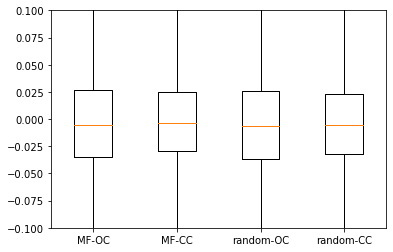

In [11]:
# 박스플롯으로 시각화해서 비교
plt.boxplot([ror_list_OC, ror_list_CC, ror_list_random_OC, ror_list_random_CC])
plt.xticks(range(1, 5), ["MF-OC", "MF-CC", "random-OC", "random-CC"])
plt.ylim(-0.1, 0.1)
plt.show()

In [12]:
# 통계량 확인
result = pd.Series(ror_list_OC).describe()
result = pd.concat([result, pd.Series(ror_list_CC).describe()], axis = 1)
result = pd.concat([result, pd.Series(ror_list_random_OC).describe()], axis = 1)
result = pd.concat([result, pd.Series(ror_list_random_CC).describe()], axis = 1)
result.columns = ["MF-OC", "MF-CC", "random-OC", "random-CC"]
display(result.round(3))

,MF-OC,MF-CC,random-OC,random-CC
count,399904.000,399904.000,365592.000,365592.000
mean,-0.000,0.002,-0.002,-0.001
std,0.076,0.069,0.077,0.070
min,-0.937,-0.937,-0.766,-0.666
25%,-0.035,-0.029,-0.037,-0.032
50%,-0.005,-0.003,-0.006,-0.005
75%,0.026,0.025,0.025,0.023
max,2.202,2.202,2.503,1.843
